## Setup the Env


In [1]:
import os
import sys

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/shuo


## Import Package

In [2]:
!pip install seaborn
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


## Load Data

In [3]:
os.getcwd()

'/home/sagemaker-user/capstone-2024-summer/src/shuo'

In [4]:
!pwd

/home/sagemaker-user/capstone-2024-summer/src/shuo


In [5]:
df = pd.read_parquet("../../data/crsp_2018-2023_clean_3.parquet")

In [6]:
df

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,value_weighted_return,equal_weighted_return,return_on_SP_index,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return
9263,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.008505,0.011232,0.008303,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064
9264,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.005856,0.005103,0.006399,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064
9265,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.004001,0.005272,0.004029,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064
9266,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.005804,0.003880,0.007034,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064
9267,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.001816,0.000584,0.001662,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7658917,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.002440,0.007676,0.001660,-0.007731,8.028047e+08,2.027403e+11,-0.001753,0.016253,-0.0,-0.00064
7658918,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.005218,0.009674,0.004232,0.015988,8.157429e+08,2.093278e+11,0.006185,0.001010,0.0,-0.00064
7658919,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.001995,0.005276,0.001430,0.018647,8.310971e+08,2.172820e+11,0.003881,0.001242,0.0,-0.00064
7658920,2023-12-28,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,-0.000108,0.002042,0.000370,-0.032104,8.048392e+08,2.037692e+11,-0.002012,0.004141,-0.0,-0.00064


In [7]:
df.dtypes

date                              datetime64[ns]
permno_id                                 object
ncusip_id                                 object
cusip_id                                  object
ticker                                    object
share_code                                object
share_code_type                           object
share_code_detail                         object
exchange_code                             object
company_name                              object
primary_exchange                          object
trading_status                            object
security_status                           object
naics                                     object
naics_sector                              object
naics_secondary                           object
ask_or_high_price                        float64
ask_price                                float64
bid_or_low_price                         float64
bid_price                                float64
open_price          

In [8]:
max(df.groupby("permno_id")["ticker"].nunique())

3

In [9]:
# Group by 'PERMNO' and count unique 'TICKER', then filter for those with exactly 2 unique 'TICKER'
permno_with_multiple_tickers = df.groupby("permno_id")["ticker"].nunique()
permno_with_multiple_tickers = permno_with_multiple_tickers[permno_with_multiple_tickers == 2].index

# Display the PERMNO values
# data[data['PERMNO'].isin(permno_with_multiple_tickers)]
permno_with_multiple_tickers

Index(['10696', '12431', '13407', '14882', '16048', '16692', '16851', '17830',
       '19751', '24053', '24643', '25582', '42200', '52329', '57568', '62308',
       '64282', '67598', '71563', '75034', '76082', '81540', '82303', '86783',
       '89017', '89179', '90199', '90441', '90442', '91277'],
      dtype='object', name='permno_id')

In [10]:
df[df["permno_id"].isin(permno_with_multiple_tickers)]

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,value_weighted_return,equal_weighted_return,return_on_SP_index,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return
68278,2018-01-02,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,0.008505,0.011232,0.008303,-0.005966,2.706066e+07,3.527358e+09,0.000000,0.000000,-0.0,-0.00064
68279,2018-01-03,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,0.005856,0.005103,0.006399,0.008099,2.728072e+07,3.584959e+09,0.021973,0.005694,0.0,-0.00064
68280,2018-01-04,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,0.004001,0.005272,0.004029,0.013980,2.766477e+07,3.686607e+09,0.002940,0.001681,0.0,-0.00064
68281,2018-01-05,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,0.005804,0.003880,0.007034,0.009857,2.793881e+07,3.760005e+09,0.015718,0.004005,0.0,-0.00064
68282,2018-01-08,10696,33773810,33773810,FISV,11.0,1,1,3,FISERV INC,...,0.001816,0.000584,0.001662,0.002004,2.799486e+07,3.775107e+09,0.006267,0.009789,0.0,-0.00064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7142596,2023-12-22,91277,74915M10,74915M10,QRTEA,11.0,1,1,3,QURATE RETAIL INC,...,0.002440,0.007676,0.001660,-0.017352,3.305973e+05,2.870907e+05,0.003961,0.005242,-0.0,-0.00064
7142597,2023-12-26,91277,74915M10,74915M10,QRTEA,11.0,1,1,3,QURATE RETAIL INC,...,0.005218,0.009674,0.004232,0.000346,3.307115e+05,2.872891e+05,0.003031,0.004622,0.0,-0.00064
7142598,2023-12-27,91277,74915M10,74915M10,QRTEA,11.0,1,1,3,QURATE RETAIL INC,...,0.001995,0.005276,0.001430,-0.001037,3.303689e+05,2.866941e+05,-0.002365,0.007425,-0.0,-0.00064
7142599,2023-12-28,91277,74915M10,74915M10,QRTEA,11.0,1,1,3,QURATE RETAIL INC,...,-0.000108,0.002042,0.000370,0.030863,3.407238e+05,3.049478e+05,-0.000601,0.003489,0.0,-0.00064


## Feature Engineering

In [11]:
data_1 = df[
    [
        "date",
        "permno_id",
        "naics",
        "log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
    ]
]
data_1

,date,permno_id,naics,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return
9263,2018-01-02,10104,511210.0,-0.013843,0.000000,0.000000,-0.0,-0.00064
9264,2018-01-03,10104,511210.0,0.022897,0.021973,0.005694,0.0,-0.00064
9265,2018-01-04,10104,511210.0,0.009803,0.002940,0.001681,0.0,-0.00064
9266,2018-01-05,10104,511210.0,0.006001,0.015718,0.004005,0.0,-0.00064
9267,2018-01-08,10104,511210.0,0.010467,0.006267,0.009789,0.0,-0.00064
...,...,...,...,...,...,...,...,...
7658917,2023-12-22,93436,336110.0,-0.007731,-0.001753,0.016253,-0.0,-0.00064
7658918,2023-12-26,93436,336110.0,0.015988,0.006185,0.001010,0.0,-0.00064
7658919,2023-12-27,93436,336110.0,0.018647,0.003881,0.001242,0.0,-0.00064
7658920,2023-12-28,93436,336110.0,-0.032104,-0.002012,0.004141,-0.0,-0.00064


In [12]:
data_1["naics_sector_digits"] = data_1["naics"].astype(str).str[:2]
data_1

/tmp/ipykernel_151/281497084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1["naics_sector_digits"] = data_1["naics"].astype(str).str[:2]


,date,permno_id,naics,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,naics_sector_digits
9263,2018-01-02,10104,511210.0,-0.013843,0.000000,0.000000,-0.0,-0.00064,51
9264,2018-01-03,10104,511210.0,0.022897,0.021973,0.005694,0.0,-0.00064,51
9265,2018-01-04,10104,511210.0,0.009803,0.002940,0.001681,0.0,-0.00064,51
9266,2018-01-05,10104,511210.0,0.006001,0.015718,0.004005,0.0,-0.00064,51
9267,2018-01-08,10104,511210.0,0.010467,0.006267,0.009789,0.0,-0.00064,51
...,...,...,...,...,...,...,...,...,...
7658917,2023-12-22,93436,336110.0,-0.007731,-0.001753,0.016253,-0.0,-0.00064,33
7658918,2023-12-26,93436,336110.0,0.015988,0.006185,0.001010,0.0,-0.00064,33
7658919,2023-12-27,93436,336110.0,0.018647,0.003881,0.001242,0.0,-0.00064,33
7658920,2023-12-28,93436,336110.0,-0.032104,-0.002012,0.004141,-0.0,-0.00064,33


In [13]:
data_2 = data_1[
    [
        "date",
        "permno_id",
        "naics_sector_digits",
        "log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
    ]
]
data_2

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return
9263,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064
9264,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064
9265,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064
9266,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064
9267,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064
...,...,...,...,...,...,...,...,...
7658917,2023-12-22,93436,33,-0.007731,-0.001753,0.016253,-0.0,-0.00064
7658918,2023-12-26,93436,33,0.015988,0.006185,0.001010,0.0,-0.00064
7658919,2023-12-27,93436,33,0.018647,0.003881,0.001242,0.0,-0.00064
7658920,2023-12-28,93436,33,-0.032104,-0.002012,0.004141,-0.0,-0.00064


## Model-Step 1 (Baseline)

In [14]:
data = data_2

In [15]:
train_data = data[data["date"] <= "2023-09-30"]
validation_data = data[data["date"] > "2023-09-30"]

In [16]:
train_data

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return
9263,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064
9264,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064
9265,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064
9266,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064
9267,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064
...,...,...,...,...,...,...,...,...
7658854,2023-09-25,93436,33,0.008579,0.007463,0.004510,0.0,-0.00064
7658855,2023-09-26,93436,33,-0.011688,-0.012885,-0.013534,-0.0,-0.00064
7658856,2023-09-27,93436,33,-0.014940,0.001939,0.007335,-0.0,-0.00064
7658857,2023-09-28,93436,33,0.024155,0.008335,0.010453,0.0,-0.00064


In [17]:
validation_data

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return
10709,2023-10-02,10104,54,0.007430,-0.000730,-0.005938,0.0,-0.00064
10710,2023-10-03,10104,54,-0.020737,-0.013888,-0.017027,-0.0,-0.00064
10711,2023-10-04,10104,54,0.024198,0.012632,0.006374,0.0,-0.00064
10712,2023-10-05,10104,54,0.011790,-0.003717,0.004393,0.0,-0.00064
10713,2023-10-06,10104,54,0.014750,0.025594,0.006348,0.0,-0.00064
...,...,...,...,...,...,...,...,...
7658917,2023-12-22,93436,33,-0.007731,-0.001753,0.016253,-0.0,-0.00064
7658918,2023-12-26,93436,33,0.015988,0.006185,0.001010,0.0,-0.00064
7658919,2023-12-27,93436,33,0.018647,0.003881,0.001242,0.0,-0.00064
7658920,2023-12-28,93436,33,-0.032104,-0.002012,0.004141,-0.0,-0.00064


In [18]:
first_month_data = data[data["date"] < "2018-02-01"]
first_month_data

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return
9263,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064
9264,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064
9265,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064
9266,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064
9267,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064
...,...,...,...,...,...,...,...,...
7657429,2018-01-25,93436,33,-0.024141,0.003783,0.002743,-0.0,-0.00064
7657430,2018-01-26,93436,33,0.015313,0.009715,0.012428,0.0,-0.00064
7657431,2018-01-29,93436,33,0.019297,-0.007773,-0.004058,0.0,-0.00064
7657432,2018-01-30,93436,33,-0.010671,-0.008697,-0.020804,-0.0,-0.00064


### Check and make sure no missing values

In [19]:
first_month_data.dtypes

date                              datetime64[ns]
permno_id                                 object
naics_sector_digits                       object
log_return                               float64
sector_weighted_avg_log_return           float64
sector_simple_avg_log_return             float64
weighted_avg_log_return                  float64
simple_avg_log_return                    float64
dtype: object

In [20]:
first_month_data[first_month_data["log_return"].isnull() == 1]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return


In [21]:
first_month_data[first_month_data["date"].isnull() == 1]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return


In [22]:
first_month_data.isnull().sum()

date                              0
permno_id                         0
naics_sector_digits               0
log_return                        0
sector_weighted_avg_log_return    0
sector_simple_avg_log_return      0
weighted_avg_log_return           0
simple_avg_log_return             0
dtype: int64

In [23]:
len(first_month_data)

11025

### Build Model & Get Embedding
1. The current model uses positional encodings.
2. Need to add ordinal position for each return.
3. Need to have 1 modified transformer encoder layer without residual connections + (n-1) standard layers
4. Need to connect the output of the first transformer block to the embedding layer of the fi- nal encoder block

#### Model-Step 1
Features:  
'log_return'  
'postional encoding'

In [79]:
first_month_data[:1000].head(14)

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return
9263,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064
9264,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064
9265,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064
9266,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064
9267,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064
9268,2018-01-09,10104,51,0.005497,-0.000225,-0.004949,0.0,-0.00064
9269,2018-01-10,10104,51,-0.005314,-0.003778,0.004841,-0.0,-0.00064
9270,2018-01-11,10104,51,0.003069,0.000712,0.004480,0.0,-0.00064
9271,2018-01-12,10104,51,0.011375,0.014945,0.008139,0.0,-0.00064
9272,2018-01-16,10104,51,0.001615,0.002397,-0.025936,0.0,-0.00064


/tmp/ipykernel_151/2712253493.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
/tmp/ipykernel_151/2712253493.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")


Epoch 1/20, Training Loss: 0.01751475989673155, Validation Loss: 0.013606764764544811
Epoch 2/20, Training Loss: 0.015625467685771558, Validation Loss: 0.013004491488112413
Epoch 3/20, Training Loss: 0.015389205297105463, Validation Loss: 0.01296293176859221
Epoch 4/20, Training Loss: 0.015379732410591646, Validation Loss: 0.012985772459193114
Epoch 5/20, Training Loss: 0.01537814260975728, Validation Loss: 0.012968893701884341
Epoch 6/20, Training Loss: 0.015377997503432677, Validation Loss: 0.012955294713932784
Epoch 7/20, Training Loss: 0.015377419111195775, Validation Loss: 0.012956461078051398
Epoch 8/20, Training Loss: 0.015376974010681674, Validation Loss: 0.012957584060371874
Epoch 9/20, Training Loss: 0.015377099358038052, Validation Loss: 0.012961119391578943
Epoch 10/20, Training Loss: 0.015377713600366556, Validation Loss: 0.012963442128904639
Epoch 11/20, Training Loss: 0.01537731151741718, Validation Loss: 0.012971597378379962
Epoch 12/20, Training Loss: 0.015377083999107

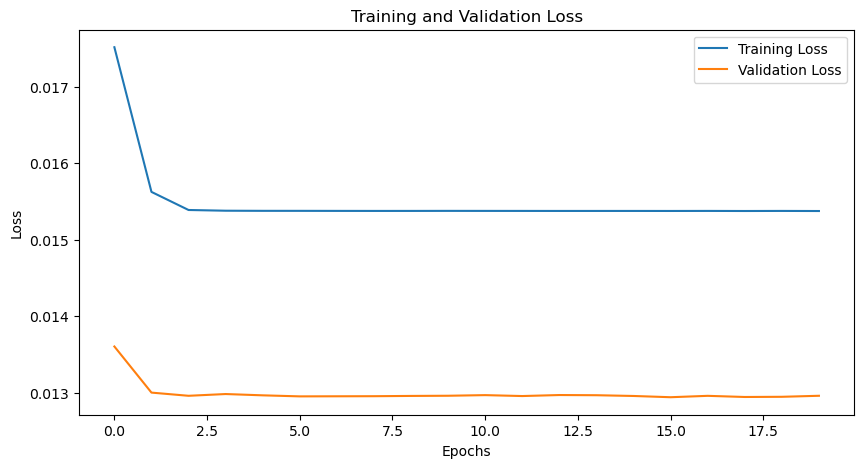

In [26]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group["log_return"].iloc[i : i + self.window_size].values
                    X = np.append(X, j)
                    j += 1

                    # print(X)
                    # t = np.arange(1, self.window_size + 1)  # Relative positions
                    # X = np.column_stack((X, t))  # Concatenate returns with positions

                    y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, n_heads, ff_dim, n_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token
        x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# # Prepare Data
# dataset = FinancialDataset(first_month_data[:1000])
# dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

train_dataset = FinancialDataset(train_data)
val_dataset = FinancialDataset(validation_data)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize Model
model = TransformerModel(input_dim=7 + 1, embed_dim=64, n_heads=8, ff_dim=256, n_layers=4)


# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

train_losses = []
val_losses = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0    
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"])
        loss = criterion(output, batch["target"])
        # print(f'loss: {loss}')
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"])
            loss = criterion(output, batch["target"])
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [40]:
dataloader = train_dataloader
dataset = train_dataset

In [29]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in dataloader:
        _, embeddings = model(batch["features"])
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [30]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [31]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-2.62327463e-04, -1.12363494e-04, -2.98447121e-04, -2.20167999e-06,
          2.12731466e-04, -1.54047200e-04,  3.53194401e-03, -5.02169365e-04,
          5.93376206e-03, -4.58115916e-04,  1.17846788e-03,  1.22237997e-03,
         -1.13176682e-03,  1.03054888e-04,  9.42305604e-04, -5.97674273e-07,
         -1.29267515e-04,  1.61200704e-04, -5.77747531e-04,  1.81348459e-03,
          9.76486554e-05,  5.79195912e-04,  8.17831678e-05, -2.22393835e-04,
         -5.10677055e-04,  2.11358129e-04,  4.94350115e-06, -6.94370901e-05,
          2.60112778e-04,  1.18025337e-05,  2.79018597e-04, -3.78407974e-04,
          8.17845503e-05, -1.07297608e-04,  3.08217248e-04, -6.83251710e-04,
          3.72437527e-04,  3.75767850e-05, -1.22296922e-06,  5.18740271e-05,
          2.47210584e-04,  9.15768906e-05,  2.92327769e-07, -4.23304082e-05,
          2.84337119e-04,  7.67948804e-04,  1.09136032e-04,  1.23957149e-03,
         -2.60892004e-04,  1.30474873e-04, -1.38724013e-03, -1.05

#### Model Features Check

In [719]:
for batch in dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  2.2897e-02,  9.8028e-03,  6.0010e-03,  1.0467e-02,
          5.4969e-03, -5.3141e-03,  7.0000e+00],
        [ 2.2897e-02,  9.8028e-03,  6.0010e-03,  1.0467e-02,  5.4969e-03,
         -5.3141e-03,  3.0693e-03,  8.0000e+00],
        [ 9.8028e-03,  6.0010e-03,  1.0467e-02,  5.4969e-03, -5.3141e-03,
          3.0693e-03,  1.1375e-02,  9.0000e+00],
        [ 6.0010e-03,  1.0467e-02,  5.4969e-03, -5.3141e-03,  3.0693e-03,
          1.1375e-02,  1.6147e-03,  1.0000e+01],
        [ 1.0467e-02,  5.4969e-03, -5.3141e-03,  3.0693e-03,  1.1375e-02,
          1.6147e-03,  1.3619e-02,  1.1000e+01],
        [ 5.4969e-03, -5.3141e-03,  3.0693e-03,  1.1375e-02,  1.6147e-03,
          1.3619e-02, -7.9632e-04,  1.2000e+01],
        [-5.3141e-03,  3.0693e-03,  1.1375e-02,  1.6147e-03,  1.3619e-02,
         -7.9632e-04,  6.9438e-03,  1.3000e+01],
        [ 3.0693e-03,  1.1375e-02,  1.6147e-03,  1.3619e-02, -7.9632e-04,
          6.9438e-03,  2.5667e-03,  1.4000e+01],
   

In [34]:
batch["features"].shape

torch.Size([14, 8])

In [35]:
batch["target"].shape

torch.Size([14])

In [36]:
len(batch["permno_id"])

14

In [37]:
batch["features"][:5]

tensor([[ 4.5825e-03, -5.1970e-02,  4.5790e-02, -1.7978e-02, -1.7085e-03,
         -1.1960e-02,  9.6151e-02,  1.4320e+03],
        [-5.1970e-02,  4.5790e-02, -1.7978e-02, -1.7085e-03, -1.1960e-02,
          9.6151e-02, -2.2549e-02,  1.4330e+03],
        [ 4.5790e-02, -1.7978e-02, -1.7085e-03, -1.1960e-02,  9.6151e-02,
         -2.2549e-02,  1.4180e-02,  1.4340e+03],
        [-1.7978e-02, -1.7085e-03, -1.1960e-02,  9.6151e-02, -2.2549e-02,
          1.4180e-02,  1.7321e-02,  1.4350e+03],
        [-1.7085e-03, -1.1960e-02,  9.6151e-02, -2.2549e-02,  1.4180e-02,
          1.7321e-02, -5.9949e-03,  1.4360e+03]])

In [38]:
model(batch["features"])

(tensor([0.0026, 0.0026, 0.0026, 0.0026, 0.0026, 0.0026, 0.0026, 0.0026, 0.0026,
         0.0026, 0.0026, 0.0026, 0.0026, 0.0026], grad_fn=<SqueezeBackward1>),
 tensor([[-2.6233e-04, -1.1236e-04, -2.9845e-04, -2.2017e-06,  2.1273e-04,
          -1.5404e-04,  3.5320e-03, -5.0217e-04,  5.9338e-03, -4.5811e-04,
           1.1784e-03,  1.2224e-03, -1.1318e-03,  1.0305e-04,  9.4229e-04,
          -5.9767e-07, -1.2927e-04,  1.6120e-04, -5.7774e-04,  1.8135e-03,
           9.7650e-05,  5.7920e-04,  8.1782e-05, -2.2239e-04, -5.1067e-04,
           2.1136e-04,  4.9436e-06, -6.9436e-05,  2.6011e-04,  1.1803e-05,
           2.7902e-04, -3.7841e-04,  8.1784e-05, -1.0730e-04,  3.0822e-04,
          -6.8326e-04,  3.7244e-04,  3.7577e-05, -1.2230e-06,  5.1874e-05,
           2.4721e-04,  9.1578e-05,  2.9233e-07, -4.2330e-05,  2.8434e-04,
           7.6795e-04,  1.0914e-04,  1.2396e-03, -2.6090e-04,  1.3048e-04,
          -1.3872e-03, -1.0550e-03,  9.8569e-06, -1.7069e-03,  1.5277e-04,
          -7.90

In [41]:
dataset.sequences[:5]

[(array([-1.38433789e-02,  2.28968548e-02,  9.80279522e-03,  6.00095818e-03,
          1.04670290e-02,  5.49686452e-03, -5.31409482e-03,  7.00000000e+00]),
  0.0030692849222946,
  '10104'),
 (array([ 2.28968548e-02,  9.80279522e-03,  6.00095818e-03,  1.04670290e-02,
          5.49686452e-03, -5.31409482e-03,  3.06928492e-03,  8.00000000e+00]),
  0.0113750580215052,
  '10104'),
 (array([ 9.80279522e-03,  6.00095818e-03,  1.04670290e-02,  5.49686452e-03,
         -5.31409482e-03,  3.06928492e-03,  1.13750580e-02,  9.00000000e+00]),
  0.0016146956770015,
  '10104'),
 (array([ 6.00095818e-03,  1.04670290e-02,  5.49686452e-03, -5.31409482e-03,
          3.06928492e-03,  1.13750580e-02,  1.61469568e-03,  1.00000000e+01]),
  0.0136188411579912,
  '10104'),
 (array([ 1.04670290e-02,  5.49686452e-03, -5.31409482e-03,  3.06928492e-03,
          1.13750580e-02,  1.61469568e-03,  1.36188412e-02,  1.10000000e+01]),
  -0.0007963169762198,
  '10104')]

In [42]:
np.array(stock_embeddings["10104"]).shape

(64,)

In [43]:
first_month_data[first_month_data["permno_id"] == "10104"]

,date,permno_id,naics_sector_digits,log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return
9263,2018-01-02,10104,51,-0.013843,0.000000,0.000000,-0.0,-0.00064
9264,2018-01-03,10104,51,0.022897,0.021973,0.005694,0.0,-0.00064
9265,2018-01-04,10104,51,0.009803,0.002940,0.001681,0.0,-0.00064
9266,2018-01-05,10104,51,0.006001,0.015718,0.004005,0.0,-0.00064
9267,2018-01-08,10104,51,0.010467,0.006267,0.009789,0.0,-0.00064
9268,2018-01-09,10104,51,0.005497,-0.000225,-0.004949,0.0,-0.00064
9269,2018-01-10,10104,51,-0.005314,-0.003778,0.004841,-0.0,-0.00064
9270,2018-01-11,10104,51,0.003069,0.000712,0.004480,0.0,-0.00064
9271,2018-01-12,10104,51,0.011375,0.014945,0.008139,0.0,-0.00064
9272,2018-01-16,10104,51,0.001615,0.002397,-0.025936,0.0,-0.00064


## Clustering the Stocks

#### K-means & squared Euclidean distances

Cluster 0: ['11308', '12431', '13035', '13379', '13447', '13586', '13721', '13856', '13964', '14277', '14542', '14702', '15069', '15707', '15850', '16087', '16431', '17750', '20482', '21207', '21792', '22517', '22592', '23473', '23819', '24010', '25582', '27887', '27991', '34746', '34833', '36468', '38093', '38703', '40539', '42906', '45911', '46674', '50876', '53065', '58819', '61399', '62092', '64282', '66157', '70519', '71563', '73139', '75510', '75607', '76095', '76226', '76709', '77129', '77661', '77730', '79089', '79545', '79785', '80924', '81472', '82307', '82581', '82651', '83621', '84373', '85058', '85621', '86580', '86964', '87056', '87267', '87432', '87842', '88664', '89003', '89071', '89179', '89393', '89641', '90071', '90248', '90319', '90664', '90829', '91103', '91611', '91926', '92121', '92203', '92402', '93429']
Cluster 1: ['10909', '18420', '18421', '18428', '18484']
Cluster 2: ['77668', '90441', '90442']
Cluster 3: ['11552', '22206', '22265', '91063']
Cluster 4: ['126

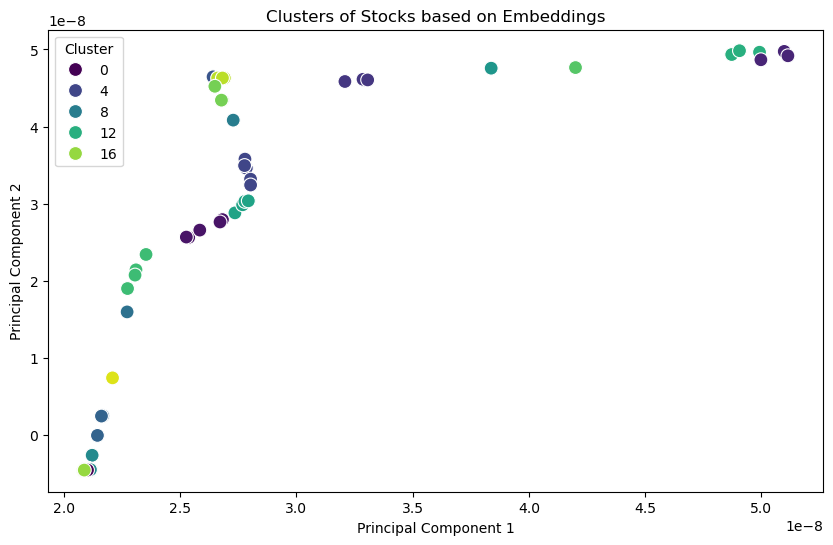

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Perform K-means clustering
n_clusters = 20  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_array)

# Create a dataframe to store permno_id and their corresponding cluster

cluster_df = pd.DataFrame({"permno_id": permno_ids, "cluster": clusters})

# Print permno_id in each cluster
for cluster in range(n_clusters):
    cluster_members = cluster_df[cluster_df["cluster"] == cluster]["permno_id"].tolist()
    print(f"Cluster {cluster}: {cluster_members}")

# Plot the clusters using PCA for dimensionality reduction

pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings_array)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=clusters,
    palette="viridis",
    s=100,
)
plt.title("Clusters of Stocks based on Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### K-means & AgglomerativeClustering

- In this approach, you directly apply Agglomerative Clustering to the original embeddings.
- The metric='cosine' parameter tells the algorithm to use cosine distance (1 - cosine similarity) as the metric for clustering.
- The linkage='average' parameter specifies that the distance between clusters is the average distance between points in the clusters.

Cluster 0: ['77668', '90442']
Cluster 1: ['18312', '79996', '82686']
Cluster 2: ['19285', '19286', '79265']
Cluster 3: ['10104', '10107', '10138', '10145', '10516', '10696', '11308', '11403', '11404', '11600', '11618', '11674', '11691', '11762', '11850', '11891', '11955', '12036', '12052', '12060', '12062', '12084', '12308', '12345', '12369', '12431', '12449', '12476', '12490', '12558', '12622', '12623', '12872', '13035', '13103', '13168', '13210', '13323', '13356', '13379', '13407', '13447', '13511', '13586', '13628', '13641', '13688', '13721', '13757', '13760', '13788', '13856', '13901', '13911', '13928', '13949', '13963', '13964', '14008', '14277', '14297', '14338', '14541', '14542', '14579', '14593', '14702', '14714', '14763', '14776', '14811', '14882', '14889', '14939', '15069', '15202', '15291', '15408', '15488', '15579', '15707', '15720', '15850', '15998', '16000', '16048', '16087', '16309', '16431', '16581', '16600', '16649', '16678', '16692', '16851', '16968', '17005', '17130'

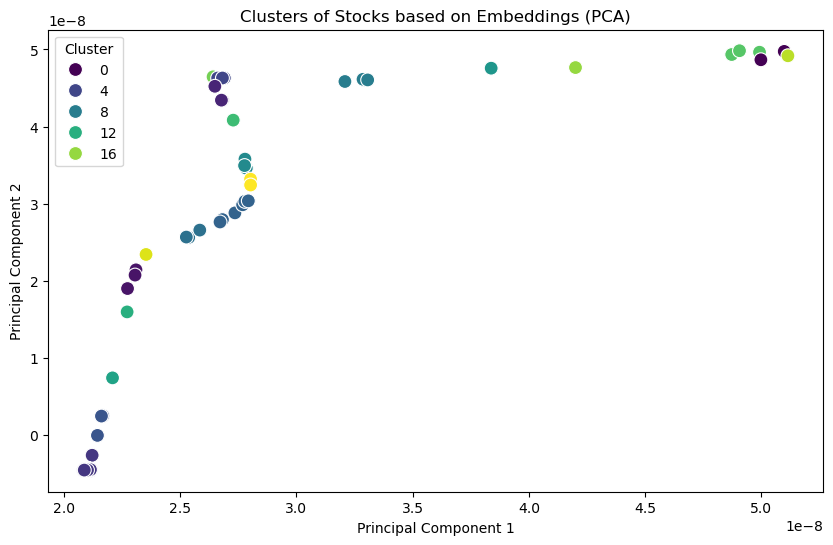

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings = np.array(list(stock_embeddings.values()))

# Perform Agglomerative Clustering with cosine affinity
n_clusters = 20
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric="cosine", linkage="average")
labels = clustering.fit_predict(embeddings)

# Map permno_id to cluster labels
permno_id_to_cluster = {permno_id: label for permno_id, label in zip(stock_embeddings.keys(), labels)}

# Create a dictionary to hold lists of permno_ids for each cluster
clusters = {i: [] for i in range(n_clusters)}
for permno_id, cluster in permno_id_to_cluster.items():
    clusters[cluster].append(permno_id)

# Print the clustering results
for cluster, permno_ids in clusters.items():
    print(f"Cluster {cluster}: {permno_ids}")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=labels,
    palette="viridis",
    s=100,
)
# for i, permno_id in enumerate(stock_embeddings.keys()):
#     plt.text(principal_components[i, 0], principal_components[i, 1], str(permno_id), fontsize=9)

plt.title("Clusters of Stocks based on Embeddings (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### K-means & Cosine Similarity
1. Cosine Similarity Transformation:  
    - Here, you first compute the cosine similarity matrix from the embeddings.
    - This matrix represents the cosine similarity between each pair of embeddings.
    - The similarity matrix is then used as the input to the KMeans clustering algorithm.  
2. KMeans Clustering:
    - KMeans is applied to the cosine similarity matrix, treating each similarity score as a feature.
    - This approach uses the similarity scores rather than the original embeddings to determine the clusters.

Cluster 0: ['11600', '11674', '13103', '13964', '14593', '14714', '17131', '22752', '23579', '25785', '39490', '39642', '46674', '49154', '49680', '60097', '65402', '66800', '76744', '77338', '77730', '79145', '82276', '82642', '85058', '85631', '85753', '88182', '88352', '89006', '90454', '92602']
Cluster 1: ['10107', '10145', '10696', '11308', '11404', '11618', '11691', '11850', '12036', '12052', '12060', '12062', '12084', '12308', '12345', '12369', '12431', '12449', '12476', '12490', '12622', '13035', '13168', '13210', '13323', '13356', '13379', '13407', '13447', '13586', '13641', '13721', '13757', '13760', '13788', '13856', '13901', '13911', '13928', '13949', '13963', '14008', '14297', '14541', '14579', '14702', '14763', '14776', '14811', '14882', '14889', '14939', '15069', '15291', '15488', '15707', '15850', '15998', '16000', '16048', '16087', '16309', '16431', '16581', '16649', '16692', '16968', '17130', '17144', '17478', '17743', '17830', '18163', '18729', '19166', '19350', '193

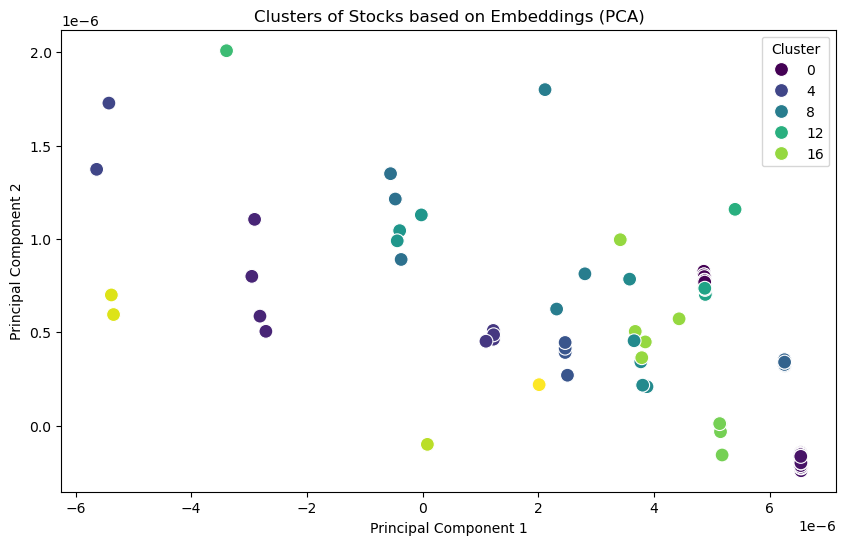

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)

# Apply KMeans on the transformed data
n_clusters = 20  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(cosine_sim_matrix)

# Map permno_id to cluster labels
permno_id_to_cluster = {permno_id: label for permno_id, label in zip(permno_ids, labels)}

# Create a dictionary to hold lists of permno_ids for each cluster
clusters = {i: [] for i in range(n_clusters)}
for permno_id, cluster in permno_id_to_cluster.items():
    clusters[cluster].append(permno_id)

# Print the clustering results
for cluster, permno_ids in clusters.items():
    print(f"Cluster {cluster}: {permno_ids}")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cosine_sim_matrix)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=labels,
    palette="viridis",
    s=100,
)
# for i, permno_id in enumerate(permno_ids):
#     plt.text(principal_components[i, 0], principal_components[i, 1], str(permno_id), fontsize=9)

plt.title("Clusters of Stocks based on Embeddings (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### Difference - AgglomerativeClustering and Cosine Similarity

Approach 1: Transforming Embeddings using Cosine Similarity and then Applying KMeans  
Approach 2: Agglomerative Clustering with Cosine Affinity  

1. Cosine Similarity Matrix vs. Original Embeddings:
    - Approach 1: Uses the cosine similarity matrix as the input for clustering. This means the clustering is based on the similarity scores between embeddings.  
    - Approach 2: Uses the original embeddings directly with cosine distance as the metric. The clustering is based on the pairwise cosine distances between embeddings.  
2. Clustering Algorithm:
    - Approach 1: Uses KMeans, which is a centroid-based algorithm. It aims to partition the data into clusters such that the sum of the squared distances from each point to its assigned centroid is minimized.  
    - Approach 2: Uses Agglomerative Clustering, which is a hierarchical clustering method. It builds a tree-like structure of clusters by merging pairs of clusters iteratively based on the specified linkage criterion and distance metric.  
3. Distance Metric Usage:  
    - Approach 1: Cosine similarity is precomputed and used as the input for clustering.  
    - Approach 2: Cosine distance is used directly within the clustering algorithm.|

#### Cosine Similarity Matrix

In [47]:
cosine_sim_matrix

array([[0.9999999 , 0.99999976, 0.9999998 , ..., 0.99999976, 0.99999976,
        0.9999999 ],
       [0.99999976, 0.9999997 , 0.9999997 , ..., 0.9999997 , 0.9999997 ,
        0.99999976],
       [0.9999998 , 0.9999997 , 0.99999976, ..., 0.9999997 , 0.9999997 ,
        0.9999998 ],
       ...,
       [0.99999976, 0.9999997 , 0.9999997 , ..., 0.9999997 , 0.9999997 ,
        0.99999976],
       [0.99999976, 0.9999997 , 0.9999997 , ..., 0.9999997 , 0.9999997 ,
        0.99999976],
       [0.9999999 , 0.99999976, 0.9999998 , ..., 0.99999976, 0.99999976,
        0.9999999 ]], dtype=float32)

#### check negative value in cosine_sim_matrix

In [48]:
# Check for negative values in the cosine similarity matrix
negative_values = cosine_sim_matrix[cosine_sim_matrix < 0]

if len(negative_values) > 0:
    print(f"There are {len(negative_values)} negative values in the cosine similarity matrix.")
    print(negative_values)
else:
    print("There are no negative values in the cosine similarity matrix.")

There are no negative values in the cosine similarity matrix.


In [49]:
# Find the maximum value in the cosine similarity matrix
max_value = np.max(cosine_sim_matrix)
print(f"Max value: {max_value}")

# Find the minimum value in the cosine similarity matrix
min_value = np.min(cosine_sim_matrix)
print(f"Min value: {min_value}")

Max value: 1.0000003576278687
Min value: 0.9999997019767761


Sample embeddings:
[[-2.62327463e-04 -1.12363494e-04 -2.98447121e-04 -2.20167999e-06
   2.12731466e-04 -1.54047200e-04  3.53194401e-03 -5.02169365e-04
   5.93376206e-03 -4.58115916e-04  1.17846788e-03  1.22237997e-03
  -1.13176682e-03  1.03054888e-04  9.42305604e-04 -5.97674273e-07
  -1.29267515e-04  1.61200704e-04 -5.77747531e-04  1.81348459e-03
   9.76486554e-05  5.79195912e-04  8.17831678e-05 -2.22393835e-04
  -5.10677055e-04  2.11358129e-04  4.94350115e-06 -6.94370901e-05
   2.60112778e-04  1.18025337e-05  2.79018597e-04 -3.78407974e-04
   8.17845503e-05 -1.07297608e-04  3.08217248e-04 -6.83251710e-04
   3.72437527e-04  3.75767850e-05 -1.22296922e-06  5.18740271e-05
   2.47210584e-04  9.15768906e-05  2.92327769e-07 -4.23304082e-05
   2.84337119e-04  7.67948804e-04  1.09136032e-04  1.23957149e-03
  -2.60892004e-04  1.30474873e-04 -1.38724013e-03 -1.05503167e-03
   9.85705901e-06 -1.70693058e-03  1.52767869e-04 -7.90970225e-05
   2.30462058e-04  7.86131277e-05  2.47300195e-04 -9.2486

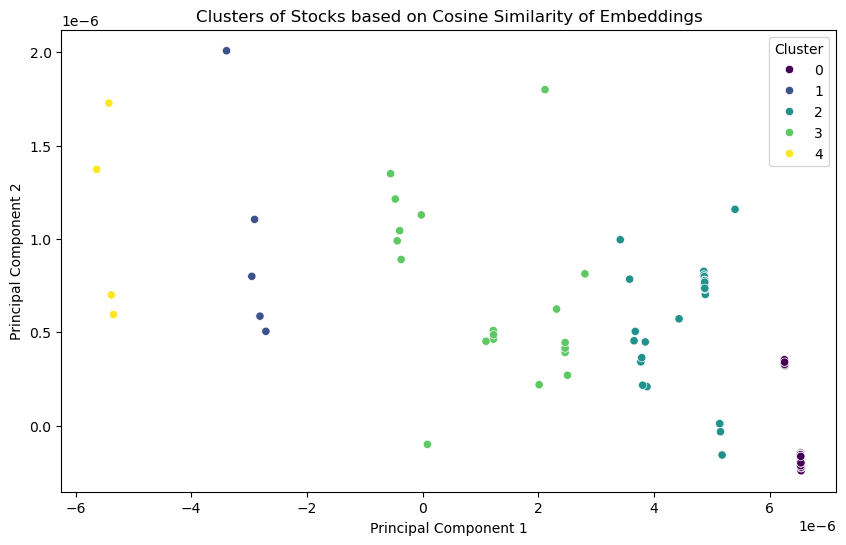

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Check the embeddings to ensure they have diverse values
print("Sample embeddings:")
print(embeddings_array[:5])

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)

# Check if there are any negative values in the cosine similarity matrix
print("Cosine Similarity Matrix Sample:")
print(cosine_sim_matrix[:5, :5])

# Ensure there are negative values
if np.any(cosine_sim_matrix < 0):
    print("Cosine similarity matrix contains negative values.")
else:
    print("Cosine similarity matrix does not contain negative values.")

# Perform K-means clustering
n_clusters = 5  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(cosine_sim_matrix)

# Create a dataframe to store permno_id and their corresponding cluster
import pandas as pd

cluster_df = pd.DataFrame({"permno_id": permno_ids, "cluster": clusters})

# Plot the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cosine_sim_matrix)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=clusters,
    palette="viridis",
)
plt.title("Clusters of Stocks based on Cosine Similarity of Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

## Clustering Stocks Return

In [51]:
list(permno_id_to_cluster.items())[:10]

[('10104', 14),
 ('10107', 1),
 ('10138', 6),
 ('10145', 1),
 ('10516', 6),
 ('10696', 1),
 ('10909', 9),
 ('11308', 1),
 ('11403', 11),
 ('11404', 1)]

In [52]:
df_clustering = df

# Add cluster_id to the original data
df_clustering["cluster_id"] = df_clustering["permno_id"].map(permno_id_to_cluster)
df_clustering

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,equal_weighted_return,return_on_SP_index,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id
9263,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.011232,0.008303,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,14
9264,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.005103,0.006399,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,14
9265,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.005272,0.004029,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,14
9266,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.003880,0.007034,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,14
9267,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.000584,0.001662,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7658917,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.007676,0.001660,-0.007731,8.028047e+08,2.027403e+11,-0.001753,0.016253,-0.0,-0.00064,11
7658918,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.009674,0.004232,0.015988,8.157429e+08,2.093278e+11,0.006185,0.001010,0.0,-0.00064,11
7658919,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.005276,0.001430,0.018647,8.310971e+08,2.172820e+11,0.003881,0.001242,0.0,-0.00064,11
7658920,2023-12-28,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.002042,0.000370,-0.032104,8.048392e+08,2.037692e+11,-0.002012,0.004141,-0.0,-0.00064,11


#### 1. Calculate the log returns of the clustering corresponding to each stock, calculated using the weighted average stock prices in the clustering

In [53]:
# First, group the data by cluster_id & date
grouped = (
    df_clustering.groupby(["cluster_id", "date"]).agg({"weighted_price": "sum", "market_cap": "sum"}).reset_index()
)

# Then, calculate the weighted average price
grouped["weighted_avg_price"] = grouped["weighted_price"] / grouped["market_cap"]

# Then, calculate the log return for each cluster_id
grouped["weighted_avg_price_shifted"] = grouped.groupby("cluster_id")["weighted_avg_price"].shift(1)
grouped["cluster_weighted_avg_log_return"] = (
    np.log(grouped["weighted_avg_price"] / grouped["weighted_avg_price_shifted"]).fillna(0)
).round(6)

grouped

,cluster_id,date,weighted_price,market_cap,weighted_avg_price,weighted_avg_price_shifted,cluster_weighted_avg_log_return
0,0,2018-01-02,2.724403e+11,2.031136e+09,134.131957,NaN,0.000000
1,0,2018-01-03,2.745722e+11,2.039307e+09,134.639972,134.131957,0.003780
2,0,2018-01-04,2.759041e+11,2.046690e+09,134.805061,134.639972,0.001225
3,0,2018-01-05,2.811508e+11,2.065263e+09,136.133184,134.805061,0.009804
4,0,2018-01-08,2.817589e+11,2.064198e+09,136.497987,136.133184,0.002676
...,...,...,...,...,...,...,...
25417,19,2018-12-17,5.266052e+09,5.449143e+07,96.640000,98.220000,-0.016217
25418,19,2018-12-18,5.092051e+09,5.358362e+07,95.030000,96.640000,-0.016800
25419,19,2018-12-19,5.174904e+09,5.401779e+07,95.800000,95.030000,0.008070
25420,19,2018-12-20,4.806810e+09,5.206119e+07,92.330000,95.800000,-0.036894


In [54]:
# Merge the clustering log returns back to the original dataframe
df_clustering = df_clustering.merge(
    grouped[["date", "cluster_id", "cluster_weighted_avg_log_return"]],
    on=["date", "cluster_id"],
    how="left",
)

df_clustering.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,return_on_SP_index,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.008303,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,14,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006399,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,14,0.021764
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.004029,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,14,0.002430
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.007034,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,14,0.016969
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.001662,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,14,0.005760


In [55]:
df_clustering["cluster_weighted_avg_log_return"]

0         0.000000
1         0.021764
2         0.002430
3         0.016969
4         0.005760
            ...   
809878    0.002708
809879    0.008723
809880    0.009865
809881   -0.016219
809882   -0.008694
Name: cluster_weighted_avg_log_return, Length: 809883, dtype: float64

#### 2. Calculate the log returns of the clustering corresponding to each stock, calculated using the arithmetic average stock prices in the clustering

In [56]:
# First, group the data by cluster_id & date
grouped = (
    df_clustering.groupby(["cluster_id", "date"])
    .agg({"close_price": "mean"})
    .reset_index()
    .rename(columns={"close_price": "avg_price"})
)

# Then, calculate the log return for each cluster_id
grouped["avg_price_Shifted"] = grouped.groupby("cluster_id")["avg_price"].shift(1)
grouped["cluster_simple_avg_log_return"] = (
    np.log(grouped["avg_price"] / grouped["avg_price_Shifted"]).fillna(0)
).round(6)

grouped

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,cluster_id,date,avg_price,avg_price_Shifted,cluster_simple_avg_log_return
0,0,2018-01-02,108.603125,NaN,0.000000
1,0,2018-01-03,109.515313,108.603125,0.008364
2,0,2018-01-04,109.613282,109.515313,0.000894
3,0,2018-01-05,110.380938,109.613282,0.006979
4,0,2018-01-08,111.411250,110.380938,0.009291
...,...,...,...,...,...
25417,19,2018-12-17,96.640000,98.220000,-0.016217
25418,19,2018-12-18,95.030000,96.640000,-0.016800
25419,19,2018-12-19,95.800000,95.030000,0.008070
25420,19,2018-12-20,92.330000,95.800000,-0.036894


In [57]:
# Merge the clustering log returns back to the original dataframe
df_clustering = df_clustering.merge(
    grouped[["date", "cluster_id", "cluster_simple_avg_log_return"]],
    on=["date", "cluster_id"],
    how="left",
)

df_clustering.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,14,0.000000,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,14,0.021764,0.012446
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,14,0.002430,0.005958
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,14,0.016969,0.007333
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,14,0.005760,0.001717


In [58]:
df_clustering["cluster_simple_avg_log_return"]

0         0.000000
1         0.012446
2         0.005958
3         0.007333
4         0.001717
            ...   
809878    0.012161
809879    0.004755
809880    0.001919
809881    0.000032
809882   -0.003015
Name: cluster_simple_avg_log_return, Length: 809883, dtype: float64

In [59]:
df_clustering.dtypes

date                               datetime64[ns]
permno_id                                  object
ncusip_id                                  object
cusip_id                                   object
ticker                                     object
share_code                                 object
share_code_type                            object
share_code_detail                          object
exchange_code                              object
company_name                               object
primary_exchange                           object
trading_status                             object
security_status                            object
naics                                      object
naics_sector                               object
naics_secondary                            object
ask_or_high_price                         float64
ask_price                                 float64
bid_or_low_price                          float64
bid_price                                 float64


In [60]:
df_clustering

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,14,0.000000,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,14,0.021764,0.012446
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,14,0.002430,0.005958
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,14,0.016969,0.007333
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,14,0.005760,0.001717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,-0.007731,8.028047e+08,2.027403e+11,-0.001753,0.016253,-0.0,-0.00064,11,0.002708,0.012161
809879,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.015988,8.157429e+08,2.093278e+11,0.006185,0.001010,0.0,-0.00064,11,0.008723,0.004755
809880,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,0.018647,8.310971e+08,2.172820e+11,0.003881,0.001242,0.0,-0.00064,11,0.009865,0.001919
809881,2023-12-28,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,...,-0.032104,8.048392e+08,2.037692e+11,-0.002012,0.004141,-0.0,-0.00064,11,-0.016219,0.000032


## Step 3 dataset  
Including stock daily log_returns from most similar and most opposite cosine similarity 

In [61]:
df_clustering = df_clustering[['date', 'permno_id', 'log_return']]

In [62]:
df_clustering.dtypes

date          datetime64[ns]
permno_id             object
log_return           float64
dtype: object

In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_and_opposite_stocks(stock_embeddings, df_clustering, n=2):
    # Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
    embeddings_list = []
    permno_ids = []
    n=2
    
    for permno_id, embedding in stock_embeddings.items():
        permno_ids.append(permno_id)
        embeddings_list.append(embedding)
    
    # Convert the list of embeddings to a numpy array
    embeddings_array = np.array(embeddings_list)
    
    # Transform embeddings using cosine similarity
    cosine_sim_matrix = cosine_similarity(embeddings_array)
    
    # Create a DataFrame for cosine similarity matrix for better handling
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=permno_ids, columns=permno_ids)
    
    base = df_clustering.copy()[['date', 'permno_id', 'log_return']]
    
    # Initialize new columns for most similar and most opposite stocks and their log returns
    for i in range(1, n + 1):
        df_clustering[f"most_similar_{i}"] = np.nan
        # df_clustering[f"most_similar_{i}_log_return"] = np.nan
        df_clustering[f"most_opposite_{i}"] = np.nan
        # df_clustering[f"most_opposite_{i}_log_return"] = np.nan
    
    # Ensure the new columns are of the same type as 'permno_id'
    df_clustering = df_clustering.astype({f"most_similar_{i}": "object" for i in range(1, n + 1)})
    df_clustering = df_clustering.astype({f"most_opposite_{i}": "object" for i in range(1, n + 1)})
    
    # Fill new columns with permno_id and log_return of most similar and most opposite stocks
    for permno_id in df_clustering["permno_id"].unique():
        similarities = cosine_sim_df.loc[permno_id]
        sorted_similarities = similarities.sort_values(ascending=False)
        most_similar = sorted_similarities.index[1 : n + 1]  # First n most similar stocks
        most_opposite = sorted_similarities.index[-n:]  # Last n most opposite stocks
    
        for i in range(n):
            similar_permno_id = most_similar[i]
            opposite_permno_id = most_opposite[i]
    
            # Set the most similar and most opposite permno_id
            df_clustering.loc[df_clustering["permno_id"] == permno_id, f"most_similar_{i+1}"] = similar_permno_id
            df_clustering.loc[df_clustering["permno_id"] == permno_id, f"most_opposite_{i+1}"] = opposite_permno_id
    
    
    # Merge the similar stock returns
    for i in range(1, n+1):
        df_clustering = df_clustering.merge(base.rename(columns={"permno_id": f"most_similar_{i}", "log_return": f"most_similar_{i}_log_return"}), on=["date", f"most_similar_{i}"], how="left")
    
    # Merge the opposite stock returns
    for i in range(1, n+1):
        df_clustering = df_clustering.merge(base.rename(columns={"permno_id": f"most_opposite_{i}", "log_return": f"most_opposite_{i}_log_return"}), on=["date", f"most_opposite_{i}"], how="left")
    
    # for feat in ["most_similar_1", "most_opposite_1", "most_similar_2", "most_opposite_2"]:
    #     df_clustering = df_clustering.merge(base.rename(columns = {"permno_id": f"{feat}", "log_return": f"{feat}_log_return"}), on = ["date", feat], how = "left")
    
    return df_clustering

# Example usage:
df_clustering = find_similar_and_opposite_stocks(stock_embeddings, df_clustering, n=3)
df_clustering


/tmp/ipykernel_151/2281485965.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering[f"most_similar_{i}"] = np.nan
/tmp/ipykernel_151/2281485965.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering[f"most_opposite_{i}"] = np.nan
/tmp/ipykernel_151/2281485965.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,date,permno_id,log_return,most_similar_1,most_opposite_1,most_similar_2,most_opposite_2,most_similar_1_log_return,most_similar_2_log_return,most_opposite_1_log_return,most_opposite_2_log_return
0,2018-01-02,10104,-0.013843,20057,90071,22265,90199,NaN,NaN,0.014639,0.011707
1,2018-01-03,10104,0.022897,20057,90071,22265,90199,NaN,NaN,-0.000692,0.008409
2,2018-01-04,10104,0.009803,20057,90071,22265,90199,NaN,NaN,-0.011493,-0.003173
3,2018-01-05,10104,0.006001,20057,90071,22265,90199,NaN,NaN,0.006285,0.004982
4,2018-01-08,10104,0.010467,20057,90071,22265,90199,NaN,NaN,0.015199,0.012794
...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,-0.007731,91063,90071,20189,90199,NaN,-0.000298,-0.001799,0.004796
809879,2023-12-26,93436,0.015988,91063,90071,20189,90199,NaN,-0.006687,0.016070,0.007152
809880,2023-12-27,93436,0.018647,91063,90071,20189,90199,NaN,0.008278,0.008037,0.011061
809881,2023-12-28,93436,-0.032104,91063,90071,20189,90199,NaN,-0.004778,0.012418,0.001920


### Check

In [69]:
df_clustering[df_clustering["most_opposite_1"] == "90071"][["date", "permno_id", "most_opposite_1_log_return"]]

,date,permno_id,most_opposite_1_log_return
0,2018-01-02,10104,0.014639
1,2018-01-03,10104,-0.000692
2,2018-01-04,10104,-0.011493
3,2018-01-05,10104,0.006285
4,2018-01-08,10104,0.015199
...,...,...,...
809878,2023-12-22,93436,-0.001799
809879,2023-12-26,93436,0.016070
809880,2023-12-27,93436,0.008037
809881,2023-12-28,93436,0.012418


In [70]:
df_clustering[df_clustering["permno_id"] == "90071"][["date", 'permno_id', "log_return"]]

,date,permno_id,log_return
736355,2018-01-02,90071,0.014639
736356,2018-01-03,90071,-0.000692
736357,2018-01-04,90071,-0.011493
736358,2018-01-05,90071,0.006285
736359,2018-01-08,90071,0.015199
...,...,...,...
737859,2023-12-22,90071,-0.001799
737860,2023-12-26,90071,0.016070
737861,2023-12-27,90071,0.008037
737862,2023-12-28,90071,0.012418


In [71]:
nan_counts = df_clustering.isna().sum()
print(nan_counts)

date                               0
permno_id                          0
log_return                         0
most_similar_1                     0
most_opposite_1                    0
most_similar_2                     0
most_opposite_2                    0
most_similar_1_log_return     510100
most_similar_2_log_return     537686
most_opposite_1_log_return      5155
most_opposite_2_log_return      8086
dtype: int64


In [72]:
any_nans = df_clustering.isna().any()
print(any_nans)

date                          False
permno_id                     False
log_return                    False
most_similar_1                False
most_opposite_1               False
most_similar_2                False
most_opposite_2               False
most_similar_1_log_return      True
most_similar_2_log_return      True
most_opposite_1_log_return     True
most_opposite_2_log_return     True
dtype: bool


In [73]:
any_nans_overall = df_clustering.isna().any().any()
print(f"Are there any NaN values in the DataFrame? {any_nans_overall}")

Are there any NaN values in the DataFrame? True


In [74]:
rows_with_nans = df_clustering[df_clustering.isna().any(axis=1)]
rows_with_nans

,date,permno_id,log_return,most_similar_1,most_opposite_1,most_similar_2,most_opposite_2,most_similar_1_log_return,most_similar_2_log_return,most_opposite_1_log_return,most_opposite_2_log_return
0,2018-01-02,10104,-0.013843,20057,90071,22265,90199,NaN,NaN,0.014639,0.011707
1,2018-01-03,10104,0.022897,20057,90071,22265,90199,NaN,NaN,-0.000692,0.008409
2,2018-01-04,10104,0.009803,20057,90071,22265,90199,NaN,NaN,-0.011493,-0.003173
3,2018-01-05,10104,0.006001,20057,90071,22265,90199,NaN,NaN,0.006285,0.004982
4,2018-01-08,10104,0.010467,20057,90071,22265,90199,NaN,NaN,0.015199,0.012794
...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,-0.007731,91063,90071,20189,90199,NaN,-0.000298,-0.001799,0.004796
809879,2023-12-26,93436,0.015988,91063,90071,20189,90199,NaN,-0.006687,0.016070,0.007152
809880,2023-12-27,93436,0.018647,91063,90071,20189,90199,NaN,0.008278,0.008037,0.011061
809881,2023-12-28,93436,-0.032104,91063,90071,20189,90199,NaN,-0.004778,0.012418,0.001920


### replace NaN with 0 and add new columns to indicate them
1. If there was values in the columns "most_similar_log_return" and "most_opposite_log_return", then fill 1.
2. If there was NaN in the columns "most_similar_log_return" and "most_opposite_log_return", then fill 0.
3. replace the NaN with 0 for the columns "most_similar_log_return" and "most_opposite_log_return"

In [75]:
df_clustering

,date,permno_id,log_return,most_similar_1,most_opposite_1,most_similar_2,most_opposite_2,most_similar_1_log_return,most_similar_2_log_return,most_opposite_1_log_return,most_opposite_2_log_return
0,2018-01-02,10104,-0.013843,20057,90071,22265,90199,NaN,NaN,0.014639,0.011707
1,2018-01-03,10104,0.022897,20057,90071,22265,90199,NaN,NaN,-0.000692,0.008409
2,2018-01-04,10104,0.009803,20057,90071,22265,90199,NaN,NaN,-0.011493,-0.003173
3,2018-01-05,10104,0.006001,20057,90071,22265,90199,NaN,NaN,0.006285,0.004982
4,2018-01-08,10104,0.010467,20057,90071,22265,90199,NaN,NaN,0.015199,0.012794
...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,-0.007731,91063,90071,20189,90199,NaN,-0.000298,-0.001799,0.004796
809879,2023-12-26,93436,0.015988,91063,90071,20189,90199,NaN,-0.006687,0.016070,0.007152
809880,2023-12-27,93436,0.018647,91063,90071,20189,90199,NaN,0.008278,0.008037,0.011061
809881,2023-12-28,93436,-0.032104,91063,90071,20189,90199,NaN,-0.004778,0.012418,0.001920


In [76]:
# Identify the columns that are related to most similar and most opposite log returns
similar_opposite_cols = [col for col in df_clustering.columns if '_log_return' in col and ('most_similar' in col or 'most_opposite' in col)]

# Add new columns to indicate if the value was NaN
for col in similar_opposite_cols:
    df_clustering[f"{col}_was_nan"] = np.where(df_clustering[col].isna(), 0, 1)

# Replace NaN values with 0 in the identified columns
df_clustering[similar_opposite_cols] = df_clustering[similar_opposite_cols].fillna(0)

# Example check
df_clustering



,date,permno_id,log_return,most_similar_1,most_opposite_1,most_similar_2,most_opposite_2,most_similar_1_log_return,most_similar_2_log_return,most_opposite_1_log_return,most_opposite_2_log_return,most_similar_1_log_return_was_nan,most_similar_2_log_return_was_nan,most_opposite_1_log_return_was_nan,most_opposite_2_log_return_was_nan
0,2018-01-02,10104,-0.013843,20057,90071,22265,90199,0.0,0.000000,0.014639,0.011707,0,0,1,1
1,2018-01-03,10104,0.022897,20057,90071,22265,90199,0.0,0.000000,-0.000692,0.008409,0,0,1,1
2,2018-01-04,10104,0.009803,20057,90071,22265,90199,0.0,0.000000,-0.011493,-0.003173,0,0,1,1
3,2018-01-05,10104,0.006001,20057,90071,22265,90199,0.0,0.000000,0.006285,0.004982,0,0,1,1
4,2018-01-08,10104,0.010467,20057,90071,22265,90199,0.0,0.000000,0.015199,0.012794,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809878,2023-12-22,93436,-0.007731,91063,90071,20189,90199,0.0,-0.000298,-0.001799,0.004796,0,1,1,1
809879,2023-12-26,93436,0.015988,91063,90071,20189,90199,0.0,-0.006687,0.016070,0.007152,0,1,1,1
809880,2023-12-27,93436,0.018647,91063,90071,20189,90199,0.0,0.008278,0.008037,0.011061,0,1,1,1
809881,2023-12-28,93436,-0.032104,91063,90071,20189,90199,0.0,-0.004778,0.012418,0.001920,0,1,1,1


In [77]:
df_clustering.columns

Index(['date', 'permno_id', 'log_return', 'most_similar_1', 'most_opposite_1',
       'most_similar_2', 'most_opposite_2', 'most_similar_1_log_return',
       'most_similar_2_log_return', 'most_opposite_1_log_return',
       'most_opposite_2_log_return', 'most_similar_1_log_return_was_nan',
       'most_similar_2_log_return_was_nan',
       'most_opposite_1_log_return_was_nan',
       'most_opposite_2_log_return_was_nan'],
      dtype='object')

In [78]:
nan_counts = df_clustering.isna().sum()
print(nan_counts)

date                                  0
permno_id                             0
log_return                            0
most_similar_1                        0
most_opposite_1                       0
most_similar_2                        0
most_opposite_2                       0
most_similar_1_log_return             0
most_similar_2_log_return             0
most_opposite_1_log_return            0
most_opposite_2_log_return            0
most_similar_1_log_return_was_nan     0
most_similar_2_log_return_was_nan     0
most_opposite_1_log_return_was_nan    0
most_opposite_2_log_return_was_nan    0
dtype: int64


## Save the cleaned df as csv & parquet


In [51]:
df_clustering.to_csv(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.csv",
    index=False,
)
df_clustering.to_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")

In [52]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")
assert df_clustering.equals(reload)

reload.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,16,0.000000,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,16,0.010933,0.009348
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,16,-0.001095,0.000711
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,16,0.000353,0.002520
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,16,0.001616,0.002617


## Upload the parquet to s3


In [53]:
s3.upload_file(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet",
    bucket,
    "CRSP/crsp_2018-2023_clean_clustering.parquet",
)

In [54]:
reload_path = s3_download("CRSP/crsp_2018-2023_clean_clustering.parquet")

In [55]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")
assert df_clustering.equals(reload)

reload.head()

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,...,log_return,market_cap,weighted_price,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,cluster_id,cluster_weighted_avg_log_return,cluster_simple_avg_log_return
0,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,-0.013843,1.930296e+08,9.000972e+09,0.000000,0.000000,-0.0,-0.00064,16,0.000000,0.000000
1,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.022897,1.975004e+08,9.422745e+09,0.021973,0.005694,0.0,-0.00064,16,0.010933,0.009348
2,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.009803,1.994460e+08,9.609309e+09,0.002940,0.001681,0.0,-0.00064,16,-0.001095,0.000711
3,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.006001,2.006465e+08,9.725336e+09,0.015718,0.004005,0.0,-0.00064,16,0.000353,0.002520
4,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,...,0.010467,2.027577e+08,9.931072e+09,0.006267,0.009789,0.0,-0.00064,16,0.001616,0.002617
